In [139]:
%load_ext autoreload
%autoreload 2

# get project dir
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

pp = PurePath(Path.cwd()).parts[:]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'

# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
# from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from utils import *
from bars import *
from labelling import *
from mpEngine import *
from sampleWeights import *
from ffd import *

RANDOM_STATE = 777


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Chapter 4's data

In [42]:
infp=PurePath(data_dir/'processed'/'clean_IVE_fut_prices.parq')
df = pd.read_parquet(infp)
df = df.assign(dates = df.index)
dbars = dollar_bar_df(df, 'dv', 1_000_000)
dbars = dbars.drop(['dates'], axis = 1)
x = np.log(dbars.price).cumsum()

x = x[~x.index.duplicated()]
x

dates
2009-09-28 09:46:35         3.933197
2009-09-28 09:53:49         7.867764
2009-09-28 09:55:26        11.802331
2009-09-28 10:02:52        15.739047
2009-09-28 10:10:21        19.676543
2009-09-28 10:19:36        23.612868
2009-09-28 10:24:23        27.549584
2009-09-28 10:34:30        31.487859
2009-09-28 10:45:25        35.425939
2009-09-28 11:10:57        39.364371
2009-09-28 11:24:29        43.302451
2009-09-28 11:37:06        47.241648
2009-09-28 11:51:43        51.181869
2009-09-28 12:03:21        55.122072
2009-09-28 12:33:18        59.062876
2009-09-28 13:20:29        63.004035
2009-09-28 13:44:27        66.946870
2009-09-28 14:05:46        70.888258
2009-09-28 14:11:43        74.828285
2009-09-28 14:18:53        78.769284
2009-09-28 14:24:55        82.710283
2009-09-28 14:28:41        86.652370
2009-09-28 14:57:19        90.593200
2009-09-28 15:34:40        94.535170
2009-09-28 15:42:10        98.476740
2009-09-29 09:27:39       102.424902
2009-09-29 09:31:34       106.36

In [37]:
def get_optimal_ffd(data, start = 0, end = 1, interval = 10, t=1e-5):
    
    cols = ['adfStat','pVal','lags','nObs','95% conf']
    out = pd.DataFrame(columns=cols)
    
    for d in np.linspace(start,end,interval):
        try:
            dfx = fracDiff_FFD(data.to_frame(),d,thres=t)
            dfx = sm.tsa.stattools.adfuller(dfx['price'], maxlag=1,regression='c',autolag=None)
            out.loc[d]=list(dfx[:4])+[dfx[4]['5%']]
        except Exception as e:
            print(f'{d} error: {e}')
            
    return out

In [40]:
out = get_optimal_ffd(x, 0.7, 0.9, 10)

In [41]:
out

,adfStat,pVal,lags,nObs,95% conf
0.700000,1.719794,0.998176,1.0,49623.0,-2.861598
0.722222,1.455154,0.997351,1.0,49660.0,-2.861598
0.744444,1.215508,0.996091,1.0,49694.0,-2.861598
0.766667,0.993576,0.994198,1.0,49725.0,-2.861598
0.788889,0.783315,0.991362,1.0,49753.0,-2.861598
0.811111,0.588334,0.987325,1.0,49780.0,-2.861598
0.833333,0.399265,0.981467,1.0,49805.0,-2.861598
0.855556,0.208277,0.972722,1.0,49828.0,-2.861598
0.877778,0.005890,0.959016,1.0,49849.0,-2.861598
0.900000,-0.207425,0.937631,1.0,49870.0,-2.861598


In [12]:
min_ffd = out[out.pVal < 0.05].iloc[0].name
print("The min. D that makes the fracdiff stationary",min_ffd)

The min. D that makes the fracdiff stationary 1.6111111111111112


### (c) Compute the correlation of the fracdiff series to the original (untransformed) series

In [43]:
min_ffd = 2
dfx2 = fracDiff_FFD(x.to_frame(),min_ffd)
cprint(dfx2)
joined = dfx2.join(x.rename('original'),how='left')
joined.corr()

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price
2018-10-05 15:58:23 -0.000430
2018-10-05 15:59:20 -0.000086
2018-10-05 15:59:55  0.000086
2018-10-05 15:59:59  0.000086
2018-10-05 16:00:00  0.000172
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49994 entries, 2009-09-28 09:55:26 to 2018-10-05 16:00:00
Data columns (total 1 columns):
price    49994 non-null float64
dtypes: float64(1)
memory usage: 781.2 KB
None
-------------------------------------------------------------------------------



,price,original
price,1.000000,-0.000013
original,-0.000013,1.000000


### (d) Apply Engel-Granger cointegration test on the original and fracdiff series. Are they cointegrated? Why?

In [44]:
coint_pval = sm.tsa.stattools.coint(joined.price, joined.original)[1]
print("p-value: ", coint_pval)
if coint_pval < 0.05:
    print("They are cointegrated")
else:
    print("They are not cointegrated")

p-value:  0.0
They are cointegrated


### (e) Apply a Jarque-Bera normality test on the fracdiff series.

In [45]:
jb_pval = stats.jarque_bera(dfx2)[1]
print("p-value: ", jb_pval)
if jb_pval < 0.05:
    print("The series is not normally distributed")
else:
    print("The series is normally distributed")

p-value:  0.0
The series is not normally distributed


In [46]:
dfx2 = -dfx2[~dfx2.index.duplicated()]

ffd_std = dfx2.std()[0]

ffd_std

0.9400002590332018

In [48]:
def getTEvents2(gRaw, h, symmetric = True, isReturn = False):
    """
    Symmetric CUSUM Filter
    Sample a bar t iff S_t >= h at which point S_t is reset
    Multiple events are not triggered by gRaw hovering around a threshold level
    It will require a full run of length h for gRaw to trigger an event
    
    Two arguments:
        gRaw: the raw time series we wish to filter (gRaw), e.g. return
        h: threshold
        
    Return:
        pd.DatatimeIndex.append(tEvents): 
    """
    tEvents, sPos, sNeg = [], 0, 0
    if isReturn:
        diff = gRaw
    else:
        diff = gRaw.diff()
    if symmetric:
        if np.shape(h) == ():

            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sPos, sNeg = max(0,sPos+tmp), min(0,sNeg+tmp)
                if sNeg < -h and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
                elif sPos > h and tradableHour(i):
                    sPos = 0; tEvents.append(i)
        else:
            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sPos, sNeg = max(0,sPos+tmp), min(0,sNeg+tmp)
                if sNeg < -h[i] and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
                elif sPos > h[i] and tradableHour(i):
                    sPos = 0; tEvents.append(i)
    else:
        if np.shape(h) == ():

            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sAbs = sAbs+tmp
                if sAbs > h and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
                
        else:
            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sAbs = sAbs+tmp
                if sAbs > h[i] and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
            
    return pd.DatetimeIndex(tEvents)

In [49]:
tEvents = getTEvents2(dfx2,h=ffd_std)
dbars_feat = dbars.price.loc[tEvents]
frac_diff_feat = dfx2.loc[tEvents]
ftMtx = (pd.DataFrame()
         .assign(dbars=dbars_feat,
                 frac_diff_feat=frac_diff_feat)
         .drop_duplicates().dropna())
cprint(ftMtx)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        dbars  frac_diff_feat
dates                                        
2018-10-02 11:49:10  116.4980        4.754773
2018-10-02 12:12:54  116.5699       -0.000617
2018-10-04 13:44:24  116.1600       -4.754977
2018-10-04 13:54:45  116.0337        4.755023
2018-10-04 14:01:44  116.0100        0.000204
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1675 entries, 2009-11-03 11:20:59 to 2018-10-04 14:01:44
Data columns (total 2 columns):
dbars             1675 non-null float64
frac_diff_feat    1675 non-null float64
dtypes: float64(2)
memory usage: 39.3 KB
None
-------------------------------------------------------------------------------



In [50]:
def getDailyVol2(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        # I dont't think it make sense
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0


ftMtx = ftMtx[~ftMtx.index.duplicated()]
dailyVol = getDailyVol2(ftMtx.dbars)
t1 = addVerticalBarrier(tEvents, ftMtx.dbars, hour=120)

ptsl = [1,1]
#ptsl = [daily]
target=dailyVol*2
# select minRet
minRet = 0.01
# get cpu count - 1
cpus = cpu_count() - 1
events = getEvents(ftMtx.dbars,tEvents,ptsl,target,minRet,cpus,t1=t1)


2018-10-27 23:25:22.583273 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


In [51]:
close=ftMtx.dbars
out = get_Concur_Uniqueness(close,events,cpus)
labels = getBins(events, ftMtx.dbars)
clean_labels = dropLabels(labels)
# get avg uniqueness for bootstrapping

avgU = out['tW'].mean()

2018-10-27 23:25:23.103380 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes..
2018-10-27 23:25:23.359580 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes..


dropped label:  0.0 0.0012353304508956147


2018-10-27 23:25:23.617505 100.0% mpSampleW done after 0.0 minutes. Remaining 0.0 minutes.


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

In [53]:
def evaluate(X,y,clf):
    from sklearn import metrics
    # The random forest model by itself
    y_pred_rf = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
    print(metrics.classification_report(y, y_pred))

    plt.figure(figsize=(9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='clf')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [68]:
trgt = clean_labels.bin
# model data# model  
data = ftMtx.join(out,how='left').join(trgt,how='left').dropna()
data_ = data.drop(['t1'],axis = 1)
X = data_.iloc[:,:-1].values
y = data_.iloc[:,-1].values.reshape(-1,1)


              precision    recall  f1-score   support

        -1.0       0.58      0.26      0.36       184
         1.0       0.66      0.88      0.76       302

   micro avg       0.65      0.65      0.65       486
   macro avg       0.62      0.57      0.56       486
weighted avg       0.63      0.65      0.61       486



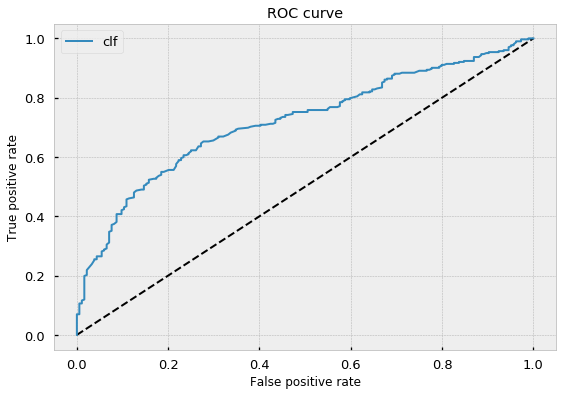

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

base_clf = DecisionTreeClassifier(criterion='entropy',max_features='auto',
                                  class_weight='balanced')
bc = BaggingClassifier(base_estimator=base_clf,n_estimators=1000,
                       max_samples=avgU,max_features=1.,random_state=RANDOM_STATE)

bc_fit  =  bc.fit(X_train, y_train)
evaluate(X_test,y_test,bc_fit)

              precision    recall  f1-score   support

        -1.0       0.59      0.26      0.36       184
         1.0       0.66      0.89      0.76       302

   micro avg       0.65      0.65      0.65       486
   macro avg       0.63      0.57      0.56       486
weighted avg       0.63      0.65      0.61       486



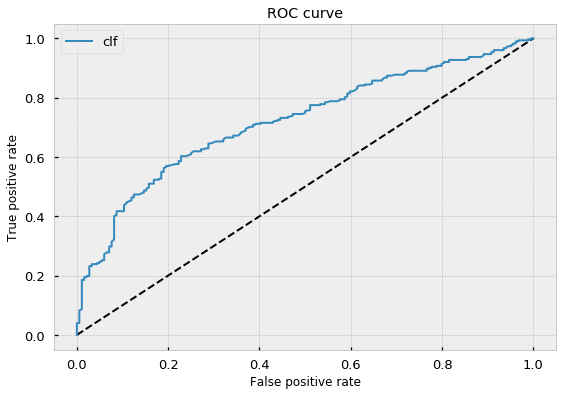

In [59]:

rf_clf  =  RandomForestClassifier(n_estimators=2,
                                class_weight='balanced_subsample',
                                criterion='entropy', 
                                bootstrap=False)
bc_rf = BaggingClassifier(base_estimator=rf_clf, n_estimators=1000,
                          max_samples=avgU, max_features=1., 
                          random_state=RANDOM_STATE)

rf_fit = bc_rf.fit(X_train,y_train)
evaluate(X_test,y_test,rf_fit)

              precision    recall  f1-score   support

        -1.0       0.48      0.20      0.28       184
         1.0       0.64      0.87      0.74       302

   micro avg       0.62      0.62      0.62       486
   macro avg       0.56      0.53      0.51       486
weighted avg       0.58      0.62      0.57       486



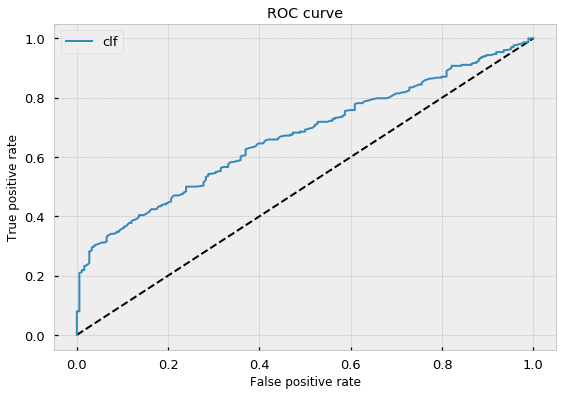

In [60]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

bc_std_fit = bc.fit(X_train_std,y_train)
evaluate(X_test_std, y_test, bc_std_fit)

              precision    recall  f1-score   support

        -1.0       0.49      0.19      0.27       184
         1.0       0.64      0.88      0.74       302

   micro avg       0.62      0.62      0.62       486
   macro avg       0.56      0.53      0.51       486
weighted avg       0.58      0.62      0.56       486



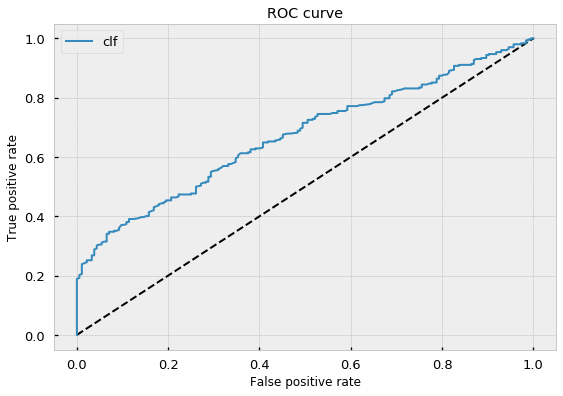

In [62]:
rf_std_fit = bc_rf.fit(X_train_std,y_train)
evaluate(X_test_std, y_test,rf_std_fit)

In [63]:
from cvFin import *

In [145]:
data = ftMtx.join(out,how='left').join(trgt,how='left').dropna()
data_ = data.drop(['t1'],axis = 1)
X = data_.iloc[:,:-1].values
y = data_.iloc[:,-1].values.reshape(-1,1)
XX = data_.iloc[:,:-1]
yy = data_.iloc[:,-1]
cvScore(rf_clf, X = XX, y = yy,
        sample_weight = XX['w'], scoring = 'neg_log_loss', t1 = data.t1, cvGen = None, cv = 10,pctEmbargo = 0.01)

array([-9.79523937])